In [300]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb

# sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

In [301]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Data Preparation

In [302]:
df = pd.read_csv('Data/CreditScoring.csv')
df.columns = df.columns.str.lower()
df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


Categorical variables are represented by numbers. For converting, we'll use the following map (extracted from [Part1_CredScoring_Processing.R](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R)). It's code in R which we'll translate to Pandas.

In [303]:
# transform numerical values to categorical
status_values = { 
    1: 'ok', 
    2:'default',
    0: 'unk'
}
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

# map number to string
df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658


In [304]:
boolean_mask = df.dtypes == 'object'

categorical = list(df.dtypes[boolean_mask].index)
printest('categorical' , categorical )

numerical  = list(df.dtypes[~boolean_mask].index)
printest('numerical' , numerical )

df[categorical].nunique()

categorical : 
 ['status', 'home', 'marital', 'records', 'job'] 

numerical : 
 ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'] 



status     3
home       7
marital    6
records    2
job        5
dtype: int64

In [305]:
# Stats for the dataset
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The maximum value is 99999999, and indicate missing values. Let's replace it by `NaN`: 

In [306]:
for i in ['income', 'assets', 'debt']:
    df[i] = df[i].replace(to_replace = 99999999, value = np.nan )

df.isna().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

For the target variable is need to exclude the status with  value 'unk'.

In [307]:
# tilde (~) operator is a bit-wise NOT operator
df = df[ ~df.status.isin(['unk'])]
print(df.status.value_counts())

ok         3200
default    1254
Name: status, dtype: int64


Now is necessary to split the dataset, handle missing values and use one-hot encode to prepare the feature matrix $\mathbf{X}$ and target variable vector $\mathbf{y}$. For this is defined a function to handle the dataset:

In [308]:
df.shape

(4454, 14)

In [309]:
def prepare_data(df):

    # split in train (60%), validation (20%) and test (20%)
    # 0.8 and 0.2
    df_train_full, df_test = train_test_split(df, test_size = 0.2,  random_state = 11)
    # 0.75 * 0.8 = 0.6 and  0.25 * 0.8 = 0.2 
    df_train, df_val = train_test_split(df_train_full, test_size = 0.25 ,  random_state = 11)

    # y is “True/1” if the client defaulted and “False/0” otherwise
    y_train = (df_train.status == 'default').values
    y_val = (df_val.status == 'default').values

    del df_train['status']
    del df_val['status']

    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)

    dict_train = df_train.to_dict(orient = 'records')
    dict_val = df_val.to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dict_train)
    X_val = dv.transform(dict_val)


    return X_train, X_val, y_train, y_val, dv

X_train, X_val, y_train, y_val, dv = prepare_data(df)

# Decision Trees - Theory

Consider a hypothetical dataset, denoted as $\mathbf{D}$, consisting of multiple attributes and a target variable:

$$\mathbf{D} =
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{d}  & \mathbf{y}\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

This matrix $\mathbf{D}$ represents our dataset. Each row corresponds to a unique client and each column (aside from the last one) corresponds to a specific attribute or feature of that client. $X_0$ is a column of ones, often called the bias or intercept term. We assume the attribute $X_j$ can be either numeric or categorical, and there are $k$ distinct classes, such that elements of $\mathbf{y} = (y_1, \cdots, y_i, \cdots, y_n)^T$ can take values $y_i \in {c_1, \cdots, c_k}$.

A decision tree is a recursive model that employs partition-based methods to predict the class $\hat{y}_i$ for each instance $\mathbf{x}_i$. The process starts with splitting the data into two subsets, denoted as $\mathbf{D}_Y$ and $\mathbf{D}_N$, by an axis-parallel hyperplane. The subsets are further divided recursively, aiming to achieve a state where the majority of points within a subset belong to the same class.

Let's now illustrate the method of using an axis-parallel hyperplane to divide our dataset into smaller subsets. A hyperplane refers to candy a plane equation for dimension higher then three, in three dimension we would have a  plane, and in two dimension we would have a line. The equation for the hyperplane is the same equation used in linear regression, with the difference that here is an inequality:

$$h(\mathbf{X}) = \mathbf{w}^T\mathbf{X}\leq 0$$

Here, the inequality expresses that we're interested in a region bounded by the hyperplane in a d-dimensional space with axes $X_{1}, \cdots,X_{j}, \cdots, X_{d}$ (excluding $X_{0}$, which isn't an axis). The weights in this case, $\mathbf{w} = (w_0, 0, \cdots, 1,\cdots, 0)^T$, are different from those in linear regression. Only the bias term $w_0$ and the jth element are non-zero, giving us:


$$w_0X_0 + 1.X_j\leq 0$$

if we call the bias term as $v = -w_0$ and knowing that $X_0$ is a unit vector, then

$$X_j\leq \mathbb{I}v$$

where selecting different values for the offset $v$ gives different hyperplanes along the dimension $X_j$. The decision or split point $X_j\leq v$ thus splits the input data space (denoted as $\mathcal{R}$) into two regions, $\mathcal{R}_Y$ (satisfying the decision) and $\mathcal{R}_N$ (not satisfying the decision).

Each split of $\mathcal{R}$ into $\mathcal{R}_Y$ and $\mathcal{R}_N$ induces a binary partition of the corresponding data points in $\mathbf{D}$. Specifically, a split point of the form $X_j\leq v$ induces the data partition

$$\mathbf{D}_Y =  \{\mathbf{x} \in \mathbf{D}| x_j \leq v\}$$
$$\mathbf{D}_N =  \{\mathbf{x} \in \mathbf{D}| x_j > v\}$$

where $\mathbf{D}_Y$ denotes the subset of data points that lie in region $\mathcal{R}_Y$ and $\mathbf{D}_N$ denotes the subset of data points that lie in $\mathcal{R}_N$.

The attribute $X_j$ in the dataset $\mathbf{D}$ could be either numeric or categorical. For numeric attributes, the split points take the form $X_j\leq v$ for some value $v$ within the attribute's range. For categorical attributes, the split points are of the form $X_j \in \mathbf{V}$ for some subset $\mathbf{V}$ of the attribute's domain.

### **Numerical**

When dealing with numerical values, an effective strategy is to consider only the midpoints between two successive distinct values of an attribute $X$ in the sample space $\mathbf{D}$. Representing these midpoints as ${v_1, \cdots, v_m}$, such that $v_1 < \cdots < v_m$, each split point $X_j\leq v$ requires us to estimate the probability mass function (PMF):

$$P(c_i|\mathbf{D}_Y) = P(c_i|X \leq v) $$

$$P(c_i|\mathbf{D}_N) = P(c_i|X > v)$$


By applying Bayes' theorem, we can compute these conditional probabilities. Here we are interested in the probability of the class $c_i$ happening given the partition dataset $\mathbf{D}_N$ or $\mathbf{D}_Y$. Using Bayes rule for the partition  $\mathbf{D}_Y$:

​$$P(c_i|X \geq v) = \frac{P(X \geq v|c_i) \cdot P(c_i)}{P(X \geq v)} = \frac{P(X \geq v|c_i) \cdot P(c_i)}{\sum_k P(X \geq v|c_k)P(c_k)} $$



**prior probability $P(c_i)$**

The prior probability for each class in dataset $\mathbf{D}$ can be estimated as follows:

$$P(c_i) = \frac{n_i}{n}$$

where $n_i$ is the total number of points in $\mathbf{D}$ of class $c_i$ and $n$ is the total number of points in $\mathbf{D}$.

**Conditional probability $P(X \geq v|c_i)$**

The conditional probability helps understand the relationship between two sets of events. Here we have the set $X \geq v$ of points from $\mathbf{D}$ that has attribute values bigger then $v$, and the set of points from $\mathbf{D}$ witch has class $c_i$ and we desire to find the relationship between this two sets. For the conditional probability can be calculated as:

$$P(X \geq v|c_i) = \frac{P((X \geq v) \cap c_i)}{P(X \geq v)} = \frac{N_{vi}}{n_i}$$

where $N_{vi}$ is the total number of points in the intersection set of the two events $X \geq v$  and $c_i$. This means that we are looking at points from $\mathbf{D}$ that has attribute values greater then v and with class $c_i$, and $n_i$ is the total number of points in $\mathbf{D}$ of class $c_i$.


Finally, the bayes rule can be written as 

$$P(c_i|\mathbf{D}_Y) = P(c_i|X \leq v) =  \frac{P(X \geq v|c_i) \cdot P(c_i)}{\sum_k P(X \geq v|c_k)P(c_k)}$$

$$P(c_i|\mathbf{D}_Y) = \frac{N_{vi}}{n} \frac{\sum_k N_{vk}}{n}$$

then the PMF for partition $\mathbf{D}_Y$ is

$$P(c_i|\mathbf{D}_Y) = \frac{N_{vi}}{\sum_k N_{vk}}$$

and for $\mathbf{D}_N$ can be calculated as $P(c_i|\mathbf{D}_N) = 1 - P(c_i|\mathbf{D}_Y)$:

$$P(c_i|\mathbf{D}_N) = \frac{n_i - N_{vi}}{\sum_k (n_k - N_{vk})}$$

### **Categorical**

For categorical values, we can use a similar process to derive the PMFs for the partition datasets $\mathbf{D}_N$ and $\mathbf{D}_Y$. In this case, $n_{vi}$ represents the number of points in the dataset $\mathbf{D}$, with attribute value $v$ for attribute X and class $c_i$. Thus, we get:

$$P(c_i|\mathbf{D}_Y) = P(c_i|X \in V) =  \frac{\sum_{v \in V} n_{vi}}{\sum_k \sum_{v \in V} n_{vk}}$$

and

$$P(c_i|\mathbf{D}_N) = P(c_i|X \notin V) =  \frac{\sum_{v \notin V} n_{vi}}{\sum_k \sum_{v \notin V} n_{vk}}$$

where $n_{vi}$ is the number of points in the dataset $\mathbf{D}$, with attribute value $v$ for attribute X and class $c_i$.

### **Evaluating split points**

For a numerical or categorical attribute split point, defined as $X\leq v$ or $X \in \mathbf{V}$, we require a scoring criterion to effectively separate the different class labels ${c_1, \cdots, c_k}$.

**Information Gain**

Information gain measures the reduction of disorder or uncertainty in a system. The goal is to use entropy as a metric for each partition, favoring a lower entropy if the partition is pure (i.e., most points have the same class label). Conversely, if class labels are mixed with no majority class, a partition has higher entropy.

The entropy of a set of labeled points $\mathbf{D}$ is defined as:

$$H(\mathbf{D}) = - \sum^{k}_{i=1} P(c_i| \mathbf{D}) \log{P(c_i| \mathbf{D})}$$

where $P(x_i| \mathbf{D})$ is the probability of class $c_i$ in $\mathbf{D}$, and $k$ is the number of classes.

When a split point partitions $\mathbf{D}$ into $\mathbf{D}_Y$ and $\mathbf{D}_N$, we define the split entropy as the weighted entropy of each of the resulting partitions:

$$H(\mathbf{D}_Y, \mathbf{D}_N) = \frac{n_Y}{n}H(\mathbf{D}_Y) + \frac{n_N}{n}H(\mathbf{D}_N)$$

where $n = |\mathbf{D}|$ is the number of points in $\mathbf{D}$, and $n_Y$ and $n_N$ are the number of points in $\mathbf{D}_Y$ and $\mathbf{D}_N$, respectively.

The information gain for a given split point, representing the reduction in overall entropy, is defined as:

$$\text{Grain}(\mathbf{D},\mathbf{D}_Y, \mathbf{D}_N) = H(\mathbf{D}) - H(\mathbf{D}_Y, \mathbf{D}_N)$$

A higher information gain corresponds to a greater reduction in entropy, thus signaling a better split point. Therefore, we can score each split point and select the one that provides the highest information gain.


**Gini Index**

The Gini index, another common purity measure for a split point, is defined as:

$$G(\mathbf{D}) = 1 - \sum_{i=1}^{k} P(c_i| \mathbf{D})^2$$

Higher Gini index values signify more disorder, while lower values indicate a higher order with respect to the class labels. The weighted Gini index of a split point is then defined as:

$$G(\mathbf{D}_Y, \mathbf{D}_N) = \frac{n_Y}{n}G(\mathbf{D}_Y) + \frac{n_N}{n}G(\mathbf{D}_N)$$


**CART**

Another useful measure is the CART, defined as:

$$\text{CART}(\mathbf{D}_Y, \mathbf{D}_N) = 2 \frac{n_Y}{n}\frac{n_N}{n} \sum_{i = 1}^k |P(c_i| \mathbf{D}_Y )  -P(c_i| \mathbf{D}_N)$$

This metric maximizes the difference between the class probability mass function for the two partitions; a higher CART value implies a better split point.



# Decision Trees

In [310]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Credit risk scoring is a binary classification problem, and for cases like that, AUC is one of the best evaluation metrics. AUC Metrics is the area under the ROC curve. The ROC curve can be plotted by the points for False positive Rate (FPR) and True Positive Rate (TPR):

$$(FPR, TPR) = \bigg(\frac{ \text{FP} }{\text{TN}+\text{FP} },\frac{\text{TP}}{\text{TP} +\text{FN}} \bigg)$$


where FP is the number of False Positives, TN for True Negatives, TP for True Positives and FN for False Negatives. For differents parameters for the classification model we can plot this points (FPR, TPR) to get the ROC curve.

In [311]:
def plot_ROC(fpr, tpr):
    plt.figure(figsize=(5, 5))

    plt.plot(fpr, tpr, color='black', linestyle='solid', label='Large')
    plt.plot(fpr, tpr, color='black', linestyle='dashed', label='Small')
    plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC curve')
    plt.legend(loc='lower right')

    plt.show()

Thresholds : 
 [2. 1. 0.] 

AUC : 
 1.0 



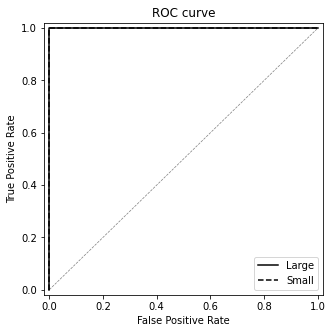

In [312]:
y_pred = dt.predict_proba(X_train)[:,1]

fpr_train, tpr_train, t_train = roc_curve(y_train, y_pred)
auc_train = roc_auc_score(y_train, y_pred)

printest("Thresholds", t_train)
printest("AUC", auc_train)

plot_ROC(fpr_train, tpr_train)


Our analysis suggests we are encountering overfitting. To corroborate this, we can apply the same model to our validation dataset. This is likely to demonstrate that the model, in its learning process, has essentially memorized the outcomes of the training data. Yet, when faced with the validation set, it failed. It lacks the ability to generalize from the patterns it learned from the training data. This is a classic manifestation of overfitting, highlighting the need for a careful balance between learning and generalization in model training.

Thresholds : 
 [0.         0.17197452 1.        ] 

AUC : 
 0.6573587464580659 



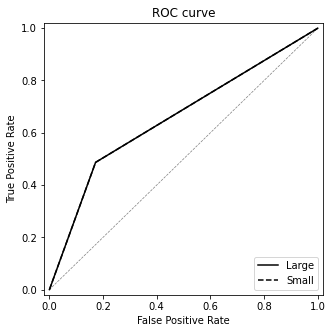

In [313]:
y_pred = dt.predict_proba(X_val)[:,1]
fpr_val, tpr_val, t_val = roc_curve(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_pred)

printest("Thresholds", fpr_val)
printest("AUC", auc_val)


plot_ROC(fpr_val, tpr_val)

We have multiple ways to control the complexity of a tree. One option is to restrict
its size: we can specify the ``max_depth`` parameter, which controls the maximum number
of levels. The more levels a tree has, the more complex rules it can learn.

In [314]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)
tree_text = export_text(dt, feature_names = dv.feature_names_)
print(tree_text)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: False
|   |--- job=partime >  0.50
|   |   |--- class: True



In [315]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
printest('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
printest('validation auc', auc)

train auc : 
 0.7054989859726213 

validation auc : 
 0.6685264343319367 

